### exp: eqtl prediction, sign prediction, gpn for machine learning

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

2024-09-17 15:18:56.160693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-17 15:18:56.177099: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-17 15:18:56.182010: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-17 15:18:56.194613: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-17 15:18:56.963870: W tensorflow/comp

In [2]:
model_size = ['small','middle','large']
model_list = ['MLP', 'CNN', 'RNN']
tissue = 'Heart_Left_Ventricle'
data_path = '../../../../../datasets_embedding/gpn/eqtl_datasets/sign_prediction/' + tissue + '/'
image_path = 'images_seed17/'
# set seed
seed = 17
import random
random.seed(seed)
np.random.seed(seed)

#### small model

In [3]:
model = model_size[0]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0   ENSG00000236423.5   chr1_3900688_T_C_b38           316  0.084098   
1   ENSG00000090432.6  chr1_20508117_C_A_b38           -44  0.134969   
2   ENSG00000228172.5  chr1_25820023_G_C_b38          -738  0.463303   
3  ENSG00000117640.17  chr1_25820023_G_C_b38          -775  0.463303   
4  ENSG00000000938.12  chr1_27634281_G_A_b38          -996  0.067278   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0         52       55  1.657173e-06  0.342601  0.069935      1   
1         82       88  6.482217e-12  0.276024  0.038419      1   
2        242      303  4.628220e-23  0.513832  0.047313      1   
3        242      303  9.349158e-65  0.530491  0.023360      1   
4         42       44  2.717342e-12  0.523637  0.071486      1   

                                          seq_before  \
0  AGGAGAGCCTCCATGCAGCTCAGAGCCTCCCAAGTGGACCGGGACC...   
1  agcccagatcccgccactgcactccagcctgggcgacacagcaaga...   
2 

In [4]:
print(train_data['label'].unique())

[1 0]


##### model 1: mlp

accuracy:0.5789473684210527
precision:0.5789473684210527
recall:1.0
f1-score:0.7333333333333333


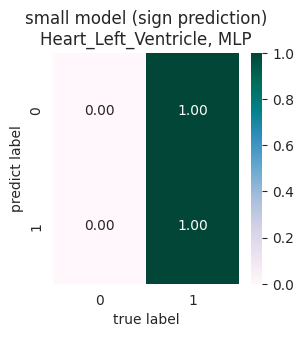

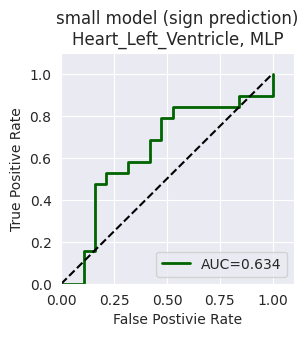

In [5]:
# model 1: mlp
from sklearn.neural_network import MLPClassifier
ml_model = model_list[0]
mlp = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_score = mlp.predict(X_test)                                   
y_score_pro = mlp.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

2024-09-17 15:18:59.733141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22446 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:18:00.0, compute capability: 8.6
2024-09-17 15:18:59.733741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22446 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:3b:00.0, compute capability: 8.6
2024-09-17 15:18:59.734249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22446 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6
I0000 00:00:1726557540.956026  589452 service.cc:146] XLA service 0x790ad000a2a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726557540.956092  589452 serv

accuracy:0.47368421052631576
precision:0.5454545454545454
recall:0.5454545454545454
f1-score:0.5454545454545454


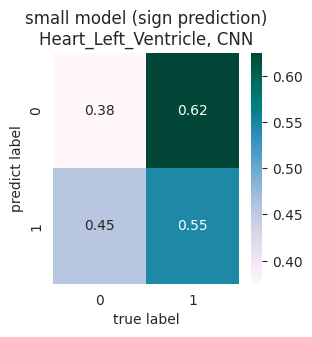

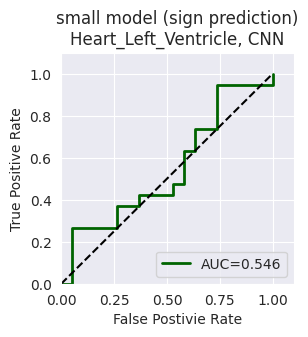

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = cnn.predict(X_test_reshape)                                   
y_score_pro = cnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

accuracy:0.5263157894736842
precision:0.75
recall:0.2727272727272727
f1-score:0.4


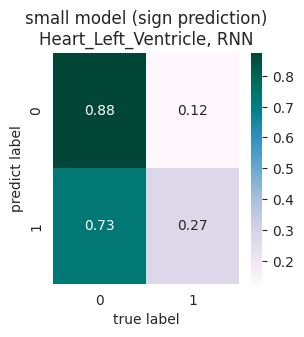

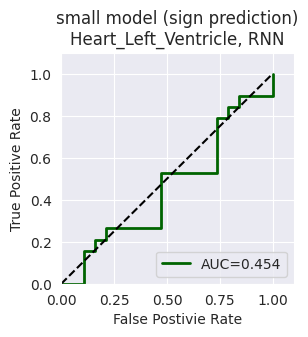

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasClassifier(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = rnn.predict(X_test_reshape)                                   
y_score_pro = rnn.predict_proba(X_test_reshape)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='PuBuGn', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('small model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#006400')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-small-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### middle model

In [8]:
model = model_size[1]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3891607_T_C_b38         -8678  0.237003   
1   ENSG00000158292.6   chr1_6262459_G_C_b38          1484  0.097859   
2  ENSG00000117122.13  chr1_16988930_G_A_b38          8095  0.422018   
3  ENSG00000183431.11  chr1_37997832_C_T_b38          6911  0.397554   
4  ENSG00000162604.12  chr1_61723869_T_C_b38         -1554  0.226300   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        134      155  1.254417e-46  0.807717  0.046026      1   
1         61       64  4.483494e-43  1.232429  0.074424      1   
2        216      276  4.477894e-16  0.309680  0.035791      1   
3        201      260  8.121680e-28  0.426557  0.034783      1   
4        131      148  3.871276e-08  0.233419  0.041253      1   

                                          seq_before  \
0  AACAAAAGAAATTAACAGCAAGCGCGGGGTGGATGTTCAAAAAAAC...   
1  TATCCAGACAGGACCTCGGTCTGCAGGAGCCCCCAGGGCAGCTTGC...   
2 

##### model 1: mlp

accuracy:0.4666666666666667
precision:0.5217391304347826
recall:0.7058823529411765
f1-score:0.6


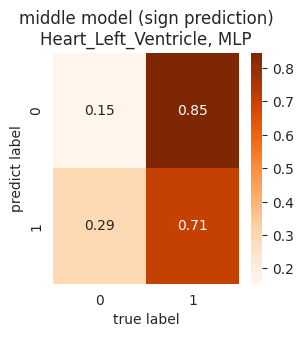

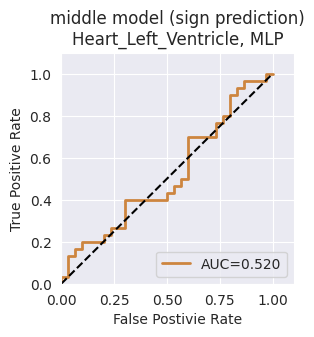

In [9]:
# model 1: mlp
from sklearn.neural_network import MLPClassifier
ml_model = model_list[0]
mlp = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_score = mlp.predict(X_test)                                   
y_score_pro = mlp.predict_proba(X_test)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

accuracy:0.43333333333333335
precision:0.5
recall:0.17647058823529413
f1-score:0.2608695652173913


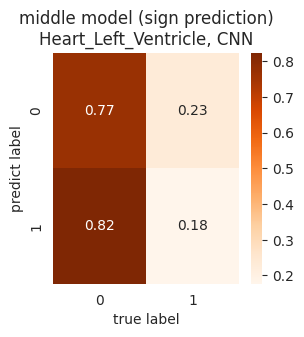

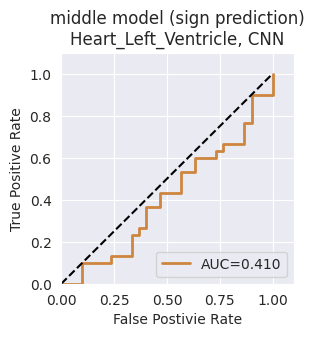

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping


import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = cnn.predict(X_test_reshape)                                   
y_score_pro = cnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

accuracy:0.43333333333333335
precision:0.5
recall:0.23529411764705882
f1-score:0.32


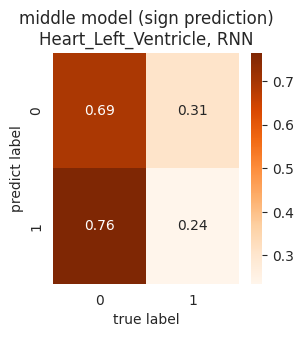

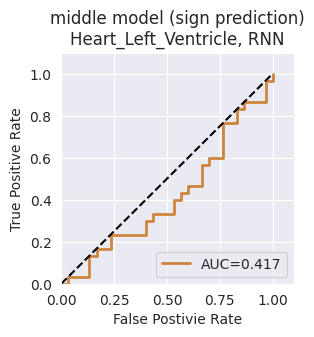

In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasClassifier(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = rnn.predict(X_test_reshape)                                   
y_score_pro = rnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='Oranges', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('middle model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#CD853F')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-middle-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

#### large model

In [12]:
model = model_size[2]
train_data = pd.read_pickle(data_path + model + '_train.dataset')
valid_data = pd.read_pickle(data_path + model + '_valid.dataset')
test_data = pd.read_pickle(data_path + model + '_test.dataset')
print(train_data.head())

train_data = train_data.sample(frac=1).reset_index(drop=True)
valid_data = valid_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)

train_data = pd.concat([train_data, valid_data]).reset_index(drop=True) # for machine learning, grid search
sample_list = []
y_list = []
for i in range(train_data.shape[0]):
    feature_list = []
    feature_list += train_data['gpn_before'][i].flatten().tolist()
    feature_list += train_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(train_data['label'][i])
X_train = np.array(sample_list)
Y_train = np.array(y_list)
print('X_train shape: ' + str(X_train.shape))
print('Y_train shape: ' + str(Y_train.shape))

sample_list = []
y_list = []
for i in range(test_data.shape[0]):
    feature_list = []
    feature_list += test_data['gpn_before'][i].flatten().tolist()
    feature_list += test_data['gpn_after'][i].flatten().tolist()
    sample_list.append(feature_list)
    y_list.append(test_data['label'][i])
X_test = np.array(sample_list)
Y_test = np.array(y_list)
print('X_test shape: ' + str(X_test.shape))
print('Y_test shape: ' + str(Y_test.shape))

         phenotype_id             variant_id  tss_distance       maf  \
0  ENSG00000198912.10   chr1_3913050_A_G_b38         12765  0.238532   
1  ENSG00000219481.10  chr1_16577626_T_G_b38        -35936  0.470948   
2  ENSG00000058453.16  chr1_16907772_T_A_b38        -14178  0.223242   
3   ENSG00000204219.9  chr1_23383982_C_T_b38        -40758  0.478593   
4  ENSG00000186501.14  chr1_27335461_C_T_b38         13316  0.012232   

  ma_samples ma_count  pval_nominal     slope  slope_se  label  \
0        135      156  1.310923e-45  0.803954  0.046565      1   
1        249      308  6.291642e-12  0.370057  0.051472      1   
2        136      146  1.943628e-24  0.406539  0.036065      1   
3        229      313  2.416720e-17  0.215370  0.023740      1   
4          8        8  1.017953e-14  1.098259  0.134080      1   

                                          seq_before  \
0  ggaagcagtatgtgggatgtgaactgaagtgcacctggaaatcctc...   
1  tatgcgctagggcacctgggggccggcagagccgttcccctacGca...   
2 

##### model 1: mlp

accuracy:0.4
precision:0.4
recall:1.0
f1-score:0.5714285714285714


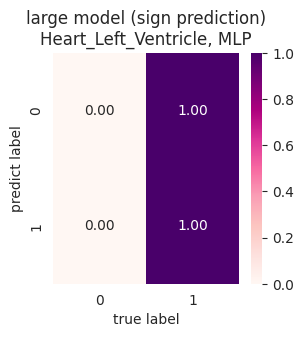

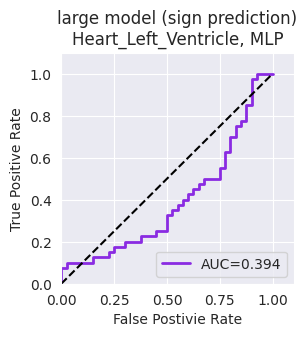

In [13]:
# model 1: mlp
from sklearn.neural_network import MLPClassifier
ml_model = model_list[0]
mlp = MLPClassifier(max_iter=1000, early_stopping=True, learning_rate_init=0.001, hidden_layer_sizes=(1024, 512, 128))

mlp.fit(X_train,Y_train)

y_score = mlp.predict(X_test)                                   
y_score_pro = mlp.predict_proba(X_test) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 2:cnn

accuracy:0.425
precision:0.40540540540540543
recall:0.9375
f1-score:0.5660377358490566


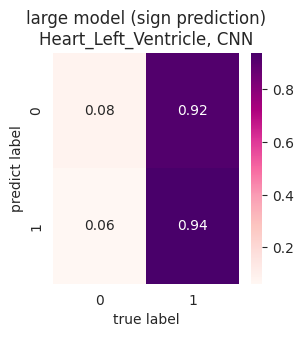

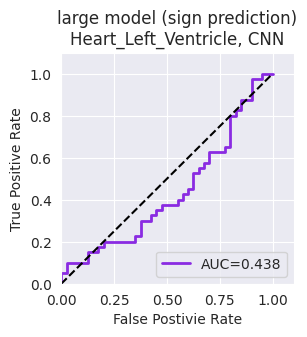

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)


def build_model(n_layers=1, kernel_size=3, strides=1, filters=16, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu', input_shape=(1024, 1)))
    model.add(layers.MaxPool1D(2, padding='same'))
    if n_layers == 2:
        # 如果有两层，添加第二层卷积层
        model.add(layers.Conv1D(filters=2*filters, kernel_size=kernel_size, strides=strides, padding='same', activation='relu'))
        model.add(layers.MaxPool1D(2, padding='same'))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

X_train_reshape = np.expand_dims(X_train, axis=-1)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

ml_model = model_list[1]
# cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=5, strides=1, filters=16, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)
cnn = KerasClassifier(model=build_model, n_layers=2, kernel_size=3, strides=1, filters=16,learning_rate=0.001, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

cnn.fit(X_train_reshape, Y_train, batch_size=16, callbacks=[early_stopping])

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = cnn.predict(X_test_reshape)                                   
y_score_pro = cnn.predict_proba(X_test_reshape) 
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

##### model 3: rnn

accuracy:0.4
precision:0.4
recall:1.0
f1-score:0.5714285714285714


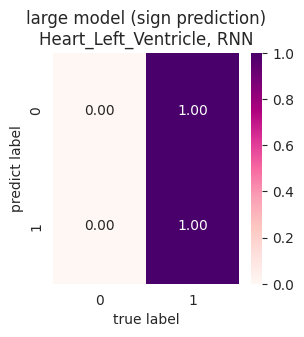

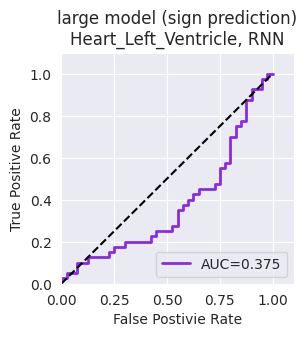

In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

def build_model(units, learning_rate=0.001):
    model = models.Sequential()
    # 添加第一层卷积层
    model.add(layers.SimpleRNN(units=units, return_sequences=True, input_shape=(1024, 1)))
    model.add(layers.Flatten(input_shape=(1024, units)))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # 编译模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['auc'])
    return model

ml_model = model_list[2]

# 早停机制
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 定义模型
rnn = KerasClassifier(model=build_model, units=8, learning_rate=0.01, epochs=1000, callbacks=[early_stopping], validation_split=0.1, verbose=0)

X_train_reshape = np.expand_dims(X_train, axis=-1)

# 执行网格搜索
rnn.fit(X_train_reshape,Y_train, verbose=0)

X_test_reshape = np.expand_dims(X_test, axis=-1)

y_score = rnn.predict(X_test_reshape)                                   
y_score_pro = rnn.predict_proba(X_test_reshape)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)
ax = plt.subplots(figsize=(3,3))
sns.heatmap(new_obj, fmt='.2f', cmap='RdPu', annot=True)
plt.xlabel("true label")
plt.ylabel("predict label")
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.savefig(image_path + 'cm-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()

fpr, tpr, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_ = auc(fpr, tpr)
#print("AUC : ", auc_)
ax = plt.subplots(figsize=(3,3))
plt.title('large model (sign prediction)\n' + tissue + ', ' + ml_model)
plt.plot(fpr, tpr, linewidth = 2,label='AUC=%.3f' % auc_,color='#8A2BE2')
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(image_path + 'auc-large-sign-' + tissue + '-' + ml_model + '.png',dpi=300, bbox_inches = 'tight')
plt.show()